In [ ]:
!pip install tf_keras

In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [29]:
# Initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 2
BS = 32
DIRECTORY = '../assets/dataset'

In [30]:
data = []
labels = []

for category in os.listdir(DIRECTORY):
    print(category)
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)
        
        data.append(image)
        labels.append(category)
        
print(labels[:10])

without_mask
with_mask


d:\Programming\Projects\Mask_detector\maskVenv\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


['without_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask']


In [31]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
print("Before: ", labels[:2]," ,type: ",type(labels))
labels = to_categorical(labels)
print("After: ", labels[:2]," ,type: ",type(labels))

print("Before-data: ", data[:2]," ,type: ",type(data))
data = np.array(data, dtype="float32")
labels = np.array(labels)
print("After-After: ", labels[:2]," ,type: ",type(labels))

Before:  [[1]
 [1]]  ,type:  <class 'numpy.ndarray'>
After:  [[0. 1.]
 [0. 1.]]  ,type:  <class 'numpy.ndarray'>
Before-data:  [array([[[ 0.94509804,  0.94509804,  0.94509804],
        [ 0.94509804,  0.94509804,  0.94509804],
        [ 0.94509804,  0.94509804,  0.94509804],
        ...,
        [ 0.92941177,  0.92941177,  0.92941177],
        [ 0.92941177,  0.92941177,  0.92941177],
        [ 0.92941177,  0.92941177,  0.92941177]],

       [[ 0.94509804,  0.94509804,  0.94509804],
        [ 0.94509804,  0.94509804,  0.94509804],
        [ 0.94509804,  0.94509804,  0.94509804],
        ...,
        [ 0.92941177,  0.92941177,  0.92941177],
        [ 0.92941177,  0.92941177,  0.92941177],
        [ 0.92941177,  0.92941177,  0.92941177]],

       [[ 0.94509804,  0.94509804,  0.94509804],
        [ 0.94509804,  0.94509804,  0.94509804],
        [ 0.94509804,  0.94509804,  0.94509804],
        ...,
        [ 0.92941177,  0.92941177,  0.92941177],
        [ 0.92941177,  0.92941177,  0.9294117

In [32]:
labels[:10]

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [33]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

In [34]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [35]:
# load the MobileNetV2 network, ensuring the head FC Layer sets are left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
                       input_tensor=Input(shape=(224,224,3)))

C:\Users\VickyWadh\AppData\Local\Temp\ipykernel_25156\3680935412.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  baseModel = MobileNetV2(weights="imagenet", include_top=False,


In [36]:
# construct the head of the model that will be placed on the top of the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7,7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [37]:
# place the head FC model on top of the base model (this will become the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [38]:
# loop over all the layers in the base model and freeze them so they will 
# *not* be updated during the first training process
for layer in baseModel.layers:
    print(layer)
    layer.trainable = False

<InputLayer name=input_layer_1, built=True>
<Conv2D name=Conv1, built=True>
<BatchNormalization name=bn_Conv1, built=True>
<ReLU name=Conv1_relu, built=True>
<DepthwiseConv2D name=expanded_conv_depthwise, built=True>
<BatchNormalization name=expanded_conv_depthwise_BN, built=True>
<ReLU name=expanded_conv_depthwise_relu, built=True>
<Conv2D name=expanded_conv_project, built=True>
<BatchNormalization name=expanded_conv_project_BN, built=True>
<Conv2D name=block_1_expand, built=True>
<BatchNormalization name=block_1_expand_BN, built=True>
<ReLU name=block_1_expand_relu, built=True>
<ZeroPadding2D name=block_1_pad, built=True>
<DepthwiseConv2D name=block_1_depthwise, built=True>
<BatchNormalization name=block_1_depthwise_BN, built=True>
<ReLU name=block_1_depthwise_relu, built=True>
<Conv2D name=block_1_project, built=True>
<BatchNormalization name=block_1_project_BN, built=True>
<Conv2D name=block_2_expand, built=True>
<BatchNormalization name=block_2_expand_BN, built=True>
<ReLU name=bl

In [45]:
import tensorflow as tf
# compile our model
print("[INFO] compiling model...")
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

[INFO] compiling model...


d:\Programming\Projects\Mask_detector\maskVenv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [46]:
# train the head of the network
print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

[INFO] training head...
Epoch 1/2


d:\Programming\Projects\Mask_detector\maskVenv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


188/188 ━━━━━━━━━━━━━━━━━━━━ 219s 1s/step - accuracy: 0.8356 - loss: 0.4183 - val_accuracy: 0.9742 - val_loss: 0.0843
Epoch 2/2


C:\Users\VickyWadh\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


188/188 ━━━━━━━━━━━━━━━━━━━━ 32s 168ms/step - accuracy: 0.9688 - loss: 0.0960 - val_accuracy: 0.9735 - val_loss: 0.0840


In [47]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

[INFO] evaluating network...
48/48 ━━━━━━━━━━━━━━━━━━━━ 35s 688ms/step


In [48]:
# for each image in the testing set we need to find the index of the label
# with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.97      0.97      0.97       745
without_mask       0.98      0.97      0.97       766

    accuracy                           0.97      1511
   macro avg       0.97      0.97      0.97      1511
weighted avg       0.97      0.97      0.97      1511



In [51]:
# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("../assets/model/mask_detector.keras")

[INFO] saving mask detector model...


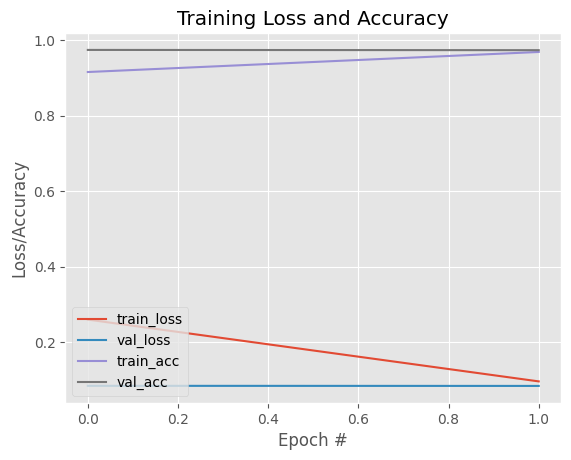

In [52]:
# plotting the training loss and accuracy
N = len(H.history['loss'])
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0,N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0,len(H.history['val_loss'])), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0,N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0,len(H.history["val_accuracy"])), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

In [53]:
H.history

{'accuracy': [0.9156405925750732, 0.96875],
 'loss': [0.25978943705558777, 0.0960015207529068],
 'val_accuracy': [0.974189281463623, 0.9735274910926819],
 'val_loss': [0.0842733383178711, 0.08401167392730713]}